In [1]:
import pandas as pd
import numpy as np

In [2]:
# Загрузим наши данные. Посмотрим на таблицы.

qid_query = pd.read_csv("open_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_query.head()

,qid,query
0,10387,batman arkham city будет русский перевод?
1,107538,Список белорусской литературы по лизингу
2,150126,написание review
3,168170,медаль в подарок на 30 лет
4,176370,что означает рожь и пшеница годом родится а ве...


In [3]:
qid_url_rating = pd.read_csv("open_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
qid_url_rating.head()

,qid,url,rating
0,10387,http://batman-arkhamcity.ru/,0.00
1,10387,http://bigtorrents.org/publ/batman_arkham_city...,0.14
2,10387,http://consolelife.ru/xbox-360/6577-o-rossiysk...,0.14
3,10387,http://dic.academic.ru/book.nsf/3662736/Batman...,0.00
4,10387,http://forum.csmania.ru/viewtopic.php?t=25986,0.14


In [4]:
hostid_url = pd.read_csv("open_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])
hostid_url.head()

,hostid,url
0,100,http://cons66.ru/
1,1000,http://www.pozdravleniya.biz/stihi/detskie/
2,1001,http://www.pravda.ru/society/family/pbringing/...
3,1002,http://www.pravpiter.ru/gorn/n015/ta003.htm
4,1003,http://www.pregnancycalendar.ru/biblioteka/vse...


In [5]:
# Делаем join двух таблиц, чтобы можно было просто брать url с максимальным рейтингом.

qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
qid_url_rating_hostid.head()

,qid,url,rating,hostid
0,10387,http://batman-arkhamcity.ru/,0.00,64
1,10387,http://bigtorrents.org/publ/batman_arkham_city...,0.14,71
2,10387,http://consolelife.ru/xbox-360/6577-o-rossiysk...,0.14,101
3,10387,http://dic.academic.ru/book.nsf/3662736/Batman...,0.00,115
4,10387,http://forum.csmania.ru/viewtopic.php?t=25986,0.14,155


In [6]:
# Функции из первого варианта решения https://yandex.ru/cup/analytics/analysis/ 
# где надо убрать цикл. Нужны для сравнения результатов.

def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]

,qid,query
12,295761,гугл переводчик


In [7]:
# Посчитаем pfound первой реализации чтобы было потом с чем сравнить.

qid_url_rating_hostid.groupby('qid').apply(pfound).mean()

0.4603173929969001

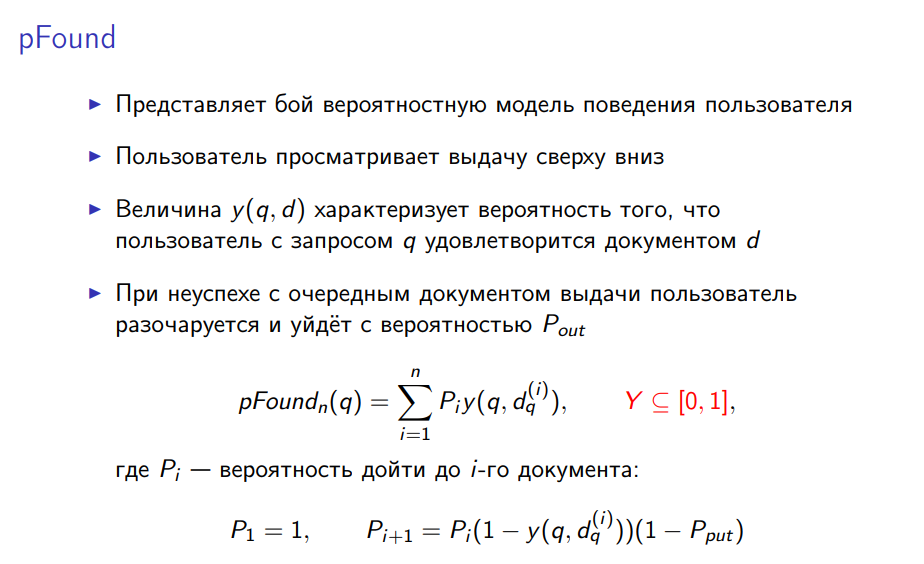

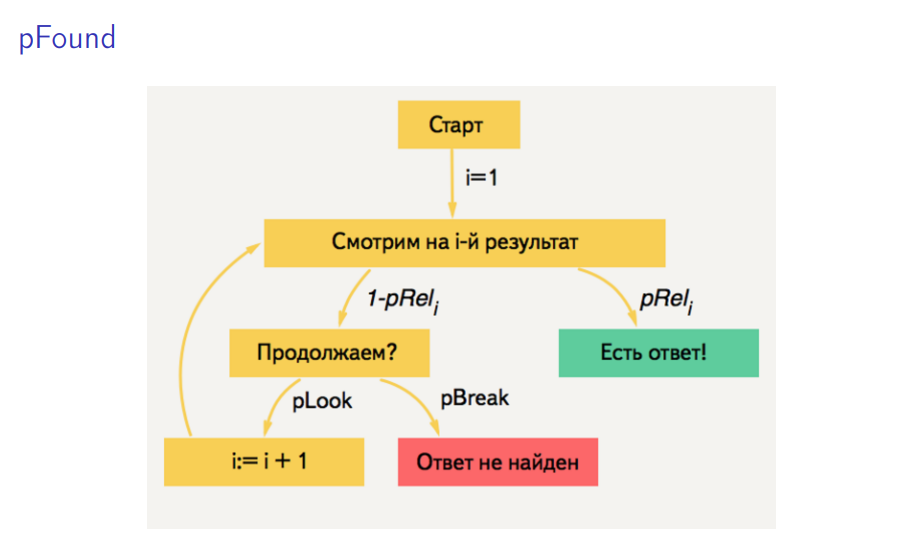

In [8]:
# Функция для подсчета pfound.

def pfound_new(df):
    top = 10
    
    # Вероятность, что пользователь прекратит поиск ничего не обнаружив.
    P_out = 0.15
    
    # Сгруппируем, отсортируем и возьмём top 10.
    qid_hostid = df.groupby(["qid", "hostid"])["rating"].max().reset_index()
    qid_hostid = qid_hostid.sort_values(["qid", "rating"], ascending=False)
    top_qid = qid_hostid.groupby("qid").head(top).reset_index(drop=True)
      
    # Посчитаем вспомогательного значения и значения для pLook[1] = 1
    top_qid["auxiliary value"] = (1 - top_qid['rating']).shift(1)*(1 - P_out) 
    top_qid.loc[top_qid.index % top == 0, "auxiliary value"] = 1
    
    # Посчитаем pLook и слагаемые формулы pfound. Посчитаем pfound.
    top_qid["pLook"] = top_qid.groupby("qid")["auxiliary value"].cumprod()
    top_qid["pfound"] = top_qid["pLook"]*top_qid["rating"]
    pfound = top_qid.groupby("qid")["pfound"].sum()
    
    return pfound

In [9]:
# Посчитаем pfound.

pfound_new(qid_url_rating_hostid).mean()

0.4603173929969002